In [100]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

from pyproj import Proj, transform

import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape


from functools import partial


from IPython.display import GeoJSON


from bokeh.io import output_notebook, show
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # offline plotly

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import warnings


init_notebook_mode(connected=True)
#output_notebook()


<bl> For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)</bl>

<bl> To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City. </bl>

<bl> PLUTO data can be downloaded from here. Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment. </bl>

## Import Data

In [101]:
zipurl = "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_17v1_1.zip"

with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('C:/Users/Admin/Desktop/HW2')

Import data to python envirenment

In [102]:
bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv', low_memory=False)
bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv', low_memory=False)
mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv', low_memory=False)
qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv', low_memory=False)
si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv', low_memory=False)

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

## Data Preparation 

The following is a geographic component preparation of the data. 


In [103]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")

nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")

ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShaderhttp://localhost:8888/notebooks/Desktop/HW2/HW2.ipynb#
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

<bl></bl>

<bl>Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.</bl>

<bl> While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year: </bl>


In [104]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

plotly.offline.iplot(fig)

Something looks off... You're going to have to deal with this imperfect data to answer this first question.

## Question

<bl> After a few building collapses, the City of New York is going to begin investigating older buildings for safety. 
The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined.</bl>

<bl> Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)</bl>

## Result

Get the bulding layout by 10 years.

In [105]:
BuildingPer10 = ny[['YearBuilt', 'NumFloors', 'BBL']]
BuildingPer10['YearBuilt'] = (np.ceil(BuildingPer10['YearBuilt'] / 10.0)* 10)

trace = go.Scatter(
    x = BuildingPer10.groupby('YearBuilt').count()['BBL'].index,
    y = BuildingPer10.groupby('YearBuilt').count()['BBL'],
    
        marker=dict(
        color='rgb(0,0,0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5,
        )
    )
)
layout = go.Layout(
    xaxis = dict(title = 'Built Time'),
    yaxis = dict(title = 'Number of Building')
)

fig = go.Figure(data = [trace], layout = layout)
plotly.offline.iplot(fig)

warnings.filterwarnings('ignore')

Get the unusual tall buildings which are the outliers or the few building above 90 percentile. 

In [106]:
TallBuilding = pd.DataFrame()

grouped = BuildingPer10.groupby(['YearBuilt', 'NumFloors'])
TallBuilding['Count'] = grouped['NumFloors'].count()
tempdf = TallBuilding.groupby(['YearBuilt'])['Count']

TallBuilding['cum'] = tempdf.cumsum() / tempdf.sum() 

UnsualFactor = 0.01 

TallBuilding['unusual'] = TallBuilding['cum'] > (1 - UnsualFactor)

TallBuilding.groupby(['YearBuilt','unusual']).filter(lambda x: (x['unusual'] == True).all())

the_unusual = TallBuilding.groupby(['YearBuilt','unusual']).sum()['Count']
trace1 = go.Bar(
    x = the_unusual.unstack(level=-1)[False].index,
    y = the_unusual.unstack(level=-1)[False],
    
    marker=dict(
        color='rgb(200,200,200)',
        line=dict(
            color='rgb(200,200,200)',
            width=1.5,
        )
    ),
    name='99%'
)

trace2 = go.Bar(
    x = the_unusual.unstack(level=-1)[True].index,
    y = the_unusual.unstack(level=-1)[True],
    
    marker=dict(
        color='rgb(100,100,100)',
        line=dict(
            color='rgb(100,100,100)',
            width=1.5,
        )
    ),
    name='1%'
)
    
layout = go.Layout(
    xaxis = dict(title = 'Built Time'),
    yaxis = dict(title = 'Floors Distribution',
                 showticklabels=False,
                 type = "log"),
    barmode = 'stack'
)
fig = go.Figure(data = [trace1, trace2], layout = layout)
plotly.offline.iplot(fig)

In [107]:
bins= BuildingPer10

getfloors = ((np.ceil(bins['NumFloors']) - 1) // 10 * 10 + 1).astype(int)
bins['Bin'] = ['{0:03d} to {1:03d} Floors'.format(x, x+9) for x in getfloors] 
grouped = bins.groupby(['YearBuilt', 'Bin', 'NumFloors'])
floors = pd.DataFrame()
floors['Count'] = grouped['NumFloors'].count()
bins_df= floors.groupby(['YearBuilt','Bin']).sum()['Count'].unstack(level=-1, fill_value=0)
bins_df['051 to 120 Floors'] = bins_df[bins_df.columns[5:11]].sum(axis=1)
bins_df = bins_df.drop(columns=bins_df.columns[5:11]).replace(0, np.nan)
warnings.filterwarnings('ignore')

In [108]:
data = [] 
for i in range(0, len(bins_df.columns)):
    trace = go.Bar(
        x = bins_df[bins_df.columns[i]].index,
        y = bins_df[bins_df.columns[i]],
        name=bins_df.columns[i],
    )
    data.append(trace) 
layout = go.Layout(
    xaxis = dict(title = 'Built Time'),
    yaxis = dict(title = 'Number of Lots Built (Log Plot)',
                 showticklabels=False,
                 type = "log"),
    barmode = 'stack'
)
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)


## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [109]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))
xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [ go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)]

plotly.offline.iplot(data)                       

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook Plotting Perils.

Here is what the same plot would look like in datashader:

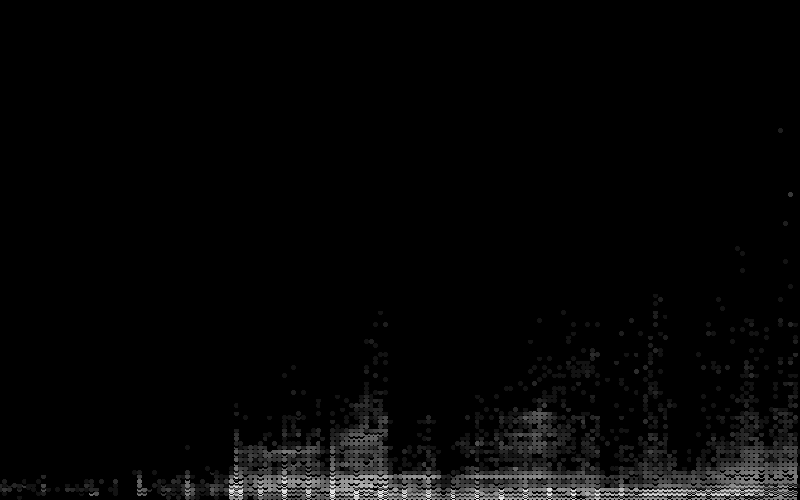

In [110]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

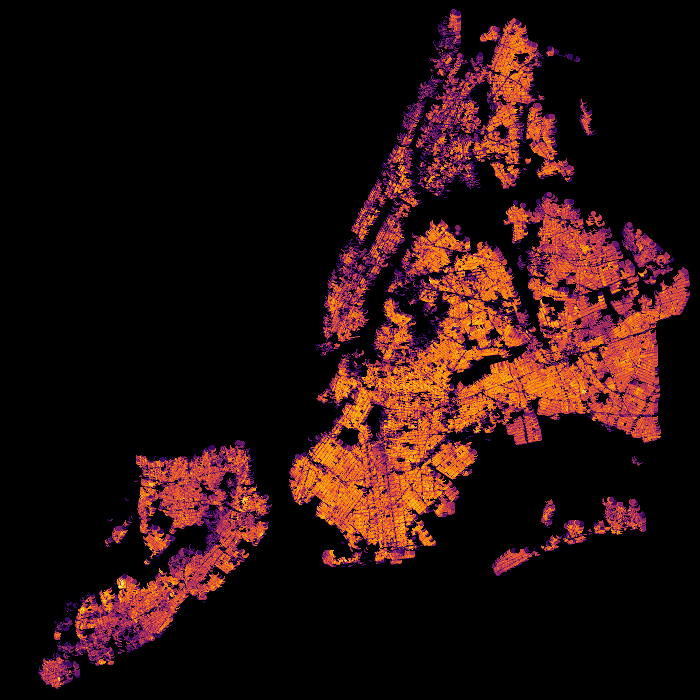

In [111]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')



Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.


## Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.


## Result

More valuable land will have more variable structures correlation can be visually illustrated using the bivariate between the two variables and display the result in normalize mode that express the relationship density of the populated variables. The bivariate will dispalyed in gategrial levelled instead of counts.


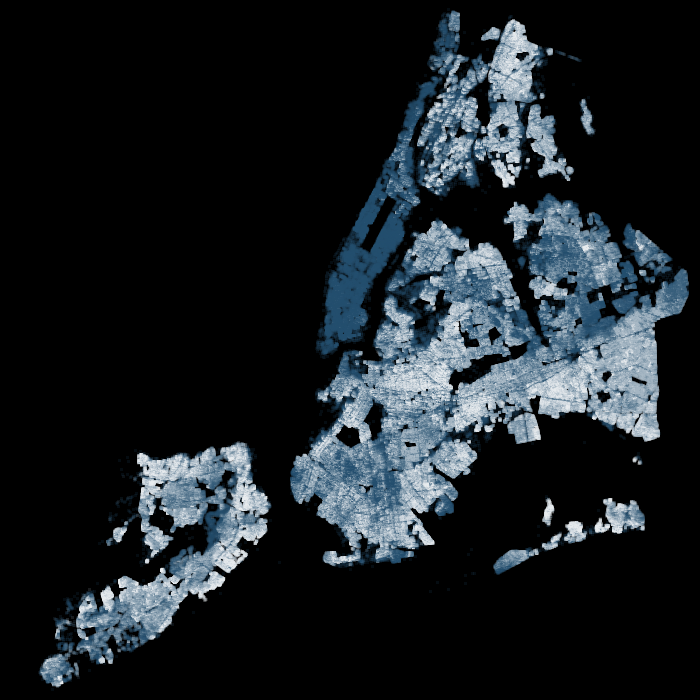

In [112]:
assessment  = ny[['AssessTot', 'AssessLand','lon','lat']]

assessment['AssessDiffrences'] = assessment['AssessTot']-assessment['AssessLand']

categories = [['A', 'B', 'C'], ['1', '2', '3']]

bins=100/3

per = np.percentile(assessment[['AssessLand', 'AssessDiffrences']], [bins, 100 - bins], axis=0) 

assessment['Category1']=pd.cut(assessment['AssessLand'], [0, per[0][0], per[1][0], np.inf], right=False, labels=categories[0])

assessment['Category2'] = pd.cut(assessment['AssessDiffrences'], [0, per[0][1], per[1][1], np.inf], right=False, labels=categories[1])


assessment['Class'] = assessment['Category1'].astype(str) + assessment['Category2'].astype(str)
assessment['Class'] = pd.Categorical(assessment['Class'])

warnings.filterwarnings('ignore')

colors = {'A1': '#e9edf0', 'A2': '#d3dbe2', 'A3': '#bdcad3', 
          'B1': '#a7b8c5', 'B2': '#91a7b7', 'B3': '#7b95a8', 
          'C1': '#4f728b', 'C2': '#39607d', 'C3': '#244f6f'}

NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(assessment, 'lon', 'lat', ds.count_cat('Class'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

